# Libraries
https://www.kaggle.com/code/ldegioanni/covid-19-papers-ranking/notebook#Part-I:-Data-Preparation

In [2]:
#Basic Sandbox
import os
import json
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

#To generate a refid for each paper (dataset + bib_entries)
import hashlib #for sha1

#To build network and compute pagerank
import networkx as nx
import math as math

#For Data viz
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
from datetime import timedelta

# Constants

$P^{2}_{author}=(0.25)*P_{coauthornetwork}(author)+(0.75)*\sum^{publication}{P_{citationnetwork}(pubilication)}$


In [3]:
#Weight parameters for Approach 2 and 3 :

weights_InfluenceScore = [0.25, 0.25, 0.25, 0.25]

# 1. Load data

- os.walk()： **for directory tree** is a Python method that generates the file names in a directory tree by walking the tree either top-down or bottom-up. For each directory in the tree rooted at directory top (including top itself), it yields a 3-tuple (dirpath, dirnames, filenames)

In [4]:
#1. Get the data
datafiles = []
for dirname, _, filenames in os.walk('/Users/Shared/Files From e.localized/Singapore/Semester2/PC5253 Complex system modeling/PageRank/Kaggle/input'):
    
    for filename in filenames:
            ifile = os.path.join(dirname, filename)
            # datafiles: 存储json文件
            if ifile.split(".")[-1] == "json":  
                datafiles.append(ifile)
            
print("Number of Files Loaded: ", len(datafiles))


Number of Files Loaded:  85371


In [5]:
#Loading metadata csv file to get the publish time
metadata = pd.read_csv("/Users/Shared/Files From e.localized/Singapore/Semester2/PC5253 Complex system modeling/PageRank//Kaggle/input/metadata_test1.csv")

In [6]:
#2. Creating of the two DataFrames:
#dfPaperList = df of Research Papers.. Variables: paper_id, paper_title, paper_authors
#dfCitationsFlat = df of all the citations . Variables: citationsId, paperId (where the citation is made),refid, title, year

authors = [] # paper id+ author name

citationsFlat = []
citationsCount = 0

for file in datafiles:
    with open(file,'r')as f:#opening a file in read mode
        doc = json.load(f)#doc is a dictionary, json.loas()return dictionary object
    paper_id = doc['paper_id']
    
    paper_authors = []

    for value in doc['metadata']['authors']:
        if len(doc['metadata']['authors']) == 0:
            paper_authors.append("NA")
        else:
            last = value["last"]
            first = value["first"]#first name ; last name
            paper_authors.append(first+" "+last)

    authors.append({"paper_id": paper_id, "authors" : paper_authors})

    for key,value in doc['bib_entries'].items():
        refid = key
        title = value['title'].lower()
        year = value['year']
        venue = value['venue'] 
        SHATitleCitation = hashlib.sha1(title.lower().encode()).hexdigest() #

        if (len(title) == 0):
            continue #there is noting we can do without any title

        citationsFlat.append({"citationId":citationsCount,\
                          "refid" : SHATitleCitation,\
                          "from": paper_id,\
                          "title": title.lower(),\
                          "year": year})
        citationsCount=citationsCount+1
        
#Conversion into DataFrame
dfCitationsFlat = pd.DataFrame(citationsFlat)# citationsId, paperId (where the citation is made),refid, title, year
authorsDf = pd.DataFrame(authors) # paper id+ author name

metadata_extract = metadata[["sha", "title", "abstract", "publish_time"]].rename(columns = {"sha" : "paper_id"})
dfPaperList = pd.merge(metadata_extract, authorsDf, on = "paper_id", how = "left")
# on the common column "paper_id" and use left join

dfPaperList["year"] = 0
dfPaperList["refid"] = ""

for i in range(len(dfPaperList)):
    
    dfPaperList["refid"][i] =  hashlib.sha1(str(dfPaperList["title"][i]).lower().encode()).hexdigest()
     #NB: We are building a custom identifier based on papers titles to ensure identification will be consistent between the papers in the Research Dataset and the papers extracted from the bib entries.
     #Unfortunately a paperId is not present for citations and doi is not provided for the whole dataset but title seem to be present for ~98% of the dataset. To enable and ease indexing capabilities we are hashing with SHA   
    dfPaperList["year"][i] = str(dfPaperList["publish_time"][i])[:4] # just want to get year
    
    try:
        dfPaperList["authors"][i] = dfPaperList["authors"][i].split(";")
    except:
        continue
        
quotationPapersFreq = pd.DataFrame({"refid" : dfCitationsFlat["refid"].value_counts().index, 
                       "nbQuotations" : dfCitationsFlat["title"].value_counts().values}) 

paperToScore = pd.merge(dfPaperList,quotationPapersFreq, on = "refid", how = "left")
paperToScore["nbQuotations"] = paperToScore["nbQuotations"].fillna(0)
#This is a Python code snippet that fills the missing values in the nbQuotations column of the paperToScore dataframe with 0.


#Adding list of references by papers according to the refid
refList = pd.DataFrame({"references" : dfCitationsFlat.groupby('from')['refid'].apply(list)}) 
refList["paper_id"] = refList.index; cols = ["paper_id","references"] ; refList = refList[cols].reset_index(drop = True) #Reformatting the reflist by papers
datasetForScoring = pd.merge(paperToScore, refList, how='left', on = 'paper_id').reset_index(drop = True)
#This code is grouping the refid column of the dfCitationsFlat dataframe by the values in the from column and applying the list function to the resulting groups. The list function creates a list of all the refid values in each group.

datasetForScoring = datasetForScoring[(datasetForScoring["authors"].isna() == False)].reset_index(drop = True)

In [10]:
#3. A few stats regarding number of papers loaded

print("Number of Papers in the CORD-19 dataset :",dfPaperList.shape[0])
#(05/14/2020) Number of Papers in the covid dataset : 63,571

print("Number of Citations found in the CORD-19 dataset :",dfCitationsFlat.shape[0])
#(05/14/2020) Number of Citations made in the covid dataset : 4,208,974

print("Citations with no title: ",sum(1 if x == "" else 0 for x in dfCitationsFlat["title"]))
#(05/14/2020) Citations with no title:  0

#How many duplicates? 
print("Number of duplicated research paper titles: ",len(dfPaperList["title"])-len(dfPaperList["title"].drop_duplicates()))
#(05/14/2020) Number of duplicated research paper titles:  1,421

print("Number of duplicated citations titles: ",len(dfCitationsFlat["title"])-len(dfCitationsFlat["title"].drop_duplicates()))
#(05/14/2020) Number of duplicated citations titles:  2,543,820

#Dataframe Visualization
print("Number of Papers that will be scored: ", datasetForScoring.shape[0])
datasetForScoring.head()

Number of Papers in the CORD-19 dataset : 63571
Number of Citations found in the CORD-19 dataset : 198965
Citations with no title:  0
Number of duplicated research paper titles:  1421
Number of duplicated citations titles:  34753
Number of Papers that will be scored:  3661


,paper_id,title,abstract,publish_time,authors,year,refid,nbQuotations,references
0,00b1d99e70f779eb4ede50059db469c65e8c1469,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"[Zhenming Xu, Jinah Choi, T Yen, Wen Lu, Anne ...",2001,592f6ad0e68ffa8c56a5cd5d2eb673bf092b02b3,0.0,"[11e6080d95677abd1aa156897750ce06c626df43, c35..."
1,0104f6ceccf92ae8567a0102f89cbb976969a774,Association of HLA class I with severe acute r...,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"[Marie Lin, Hsiang-Kuang Tseng, Jean Trejaut, ...",2003,715395044372c91c50a7f5c239da3d3109639ed4,5.0,"[96537f5bd5a15e42fbf36495faf025c2d6ccb51e, abe..."
2,06559dd625491d6474ee88f08c12fc17c1830995,"Towards evidence-based, GIS-driven national sp...","The term ""Geographic Information Systems"" (GIS...",2004-01-28,"[Maged Kamel Boulos, Email Maged, Kamel Boulos...",2004,f88df71ff4403a57739cf1a0d33c327a4b1cc9f7,0.0,"[69105540556d2b53e60e42895ac5982036d89f7f, bb4..."
3,017ca5bdac589a37196df7b8e077c4c371ab32da,Pro/con clinical debate: Isolation precautions...,Antibiotic-resistant bacteria are an increasin...,2004-02-19,[],2004,9f70eef1196e97f2ee2ef81fa2f8d95f2648d0c8,0.0,"[d9f78fe94ecc4205a938f24c0325a84770970dda, 8f6..."
4,09fc4c5e368a43d21f5130cb8474d61d65191dd9,Locked nucleic acid (LNA) mediated improvement...,Therapeutic application of the recently discov...,2005-01-14,"[Joacim Elm E En, Hå Kan Thonberg, Karl Ljungb...",2005,276dbdbf2cc914cd0f5d0b875025fbb60fdbc54b,2.0,"[1c305643e9449e60abb072de65d8ae4333a93127, b0d..."


# 2 Computation of Author Scoring and Publication pagerank

In [7]:
'''1. Creating an author dataset + Computation of the author page rank using an author network'''

#Variables for author dataset: id, name, co-authors, number of points linked to quotations, paper_count, citations, average citations,co_author_avg_citations,h-index

author_data = {}
author_id = {
    'start': 1,
    'curr': 1
}

assigned_ids = {}

def create_author_data(train_data, author_data, author_id, assigned_ids):
    for i in range(len(train_data)):
        authors = train_data.authors[i]
        #This code is accessing the i-th element of the nbQuotations list of the train_data object.
    
        try:
            citations = train_data.nbQuotations[i]/len(authors) #Number of times a paper have been quoted divided by len authors
        except:
            continue

        for author in authors:
            names = author.split(' ')
            unique_name = names[0] + "_" + names[len(names)-1]
            if unique_name not in author_data:
                author_data[unique_name] = {
                    'num_citations': citations,
                    'paper_count': 1,
                    'name': unique_name,
                    'author_id': author_id['curr'],
                    'co_authors': {},
                    'citations': [train_data.nbQuotations[i]]
                }
                assigned_ids[unique_name] = author_id['curr']
                author_id['curr'] += 1

            else:
                author_data[unique_name]['num_citations'] += citations
                author_data[unique_name]['paper_count'] += 1
                author_data[unique_name]['citations'].append(train_data.nbQuotations[i])

            for co_author in authors:
                co_author_names = co_author.split(' ')
                co_author_unique_name = co_author_names[0] + "_" + co_author_names[len(co_author_names)-1]
                if co_author_unique_name != unique_name:
                    author_data[unique_name]['co_authors'][co_author_unique_name] = 1
                        
            
            
# call for each data file
create_author_data(datasetForScoring, author_data, author_id, assigned_ids)

# add average citations
for data in author_data:
    author_data[data]['average_citations'] = author_data[data]['num_citations'] / author_data[data]['paper_count']
    
# adding h-index
def get_h_index(citations):
    return ([0] + [i + 1 for i, c in enumerate(sorted(citations, reverse = True)) if c >= i + 1])[-1]

data_to_df = []
for data in author_data:
    each_author = author_data[data]
    co_authors = each_author['co_authors']
    co_author_ids = []
    co_author_avg_citations = 0
    for co_author in co_authors:
        co_author_avg_citations += author_data[co_author]['average_citations']
        co_author_ids.append(assigned_ids[co_author])
    each_author['co_authors'] = co_author_ids
    each_author['co_author_avg_citations'] = co_author_avg_citations/len(co_author_ids) if len(co_author_ids) != 0 else 0
    data_to_df.append(each_author)
    
authorsData = pd.DataFrame.from_dict(data_to_df, orient='columns')
#h_index
authorsData['h_index'] = authorsData.apply(lambda x: get_h_index(x.citations), axis=1)

### 2. Computation of authors page rank

the explanation of How can I convert a Pandas DataFrame to a Python dictionary using the to_dict method: https://blog.gitnux.com/code/pandas-to_dict/

In [8]:
'''AUTHOR PAGE RANK'''

#Data Pre-processing: building the dataset on which the author network will be built
train = authorsData.copy().drop(columns=['num_citations', 'h_index','paper_count', 'citations']).dropna(axis = 0, subset=['co_authors'])
train = train[train.co_authors != '[]']
train['author_id'] = pd.to_numeric(train['author_id'])
#print(train.head(10))
print(train.shape)
print(len(train))

# Building up the network to compute author page rank: 
G = nx.Graph()
for i in range(len(train)):
    #select a specific row and column from a Pandas DataFrame1.
    auth = train.iloc[i]['author_id'] #select the row at index i
    G.add_node(auth)
    for neighbor in train.iloc[i]['co_authors']:
        if G.has_edge(auth, neighbor):
            G.add_edge(auth, neighbor, weight = G[auth][neighbor]['weight']+1)
        else:
            G.add_edge(auth, neighbor, weight = 1)

(4930, 5)
4930


In [9]:
'''form the edge list'''
from collections import defaultdict

edge_list=list(G.edges)
edges=defaultdict(list)
for edge in edge_list:
    _from,_to=edge[0],edge[1]
    edges[_from].append(_to)
    
Node_num=len(list(G.nodes))
print(max(list(G.nodes)))
print(len(list(G.nodes)))
#print(list(G.nodes))

4930
4930


In [10]:
score_authors = nx.pagerank(G, alpha=0.55, max_iter=100, tol=1.0e-6, nstart=None, weight='weight', dangling=None)

In [11]:
authorPRK = pd.DataFrame.from_dict(score_authors, orient = "index").reset_index(drop=False)
# The orient parameter is set to "index" to indicate that the keys of the dictionary should be used as the row labels of the DataFrame.
#print(authorPRK.head(10))
#num_rows=authorPRK.shape
#print(num_rows)

#plt.hist(R,bins=100,density=1)
authorPRK=authorPRK.sort_values(by='index')
authorPRK.set_index('index',inplace=True)
print(authorPRK.head(10))

data = authorPRK.values.tolist()
Author_pagerank_vector=np.array(data).reshape(-1)


              0
index          
1      0.000166
2      0.000166
3      0.000166
4      0.000368
5      0.000195
6      0.000195
7      0.000195
8      0.000195
9      0.000195
10     0.000195


### Trustrank method

In [24]:
import heapq
import numpy as np
#from graphs import plotGraph
from scipy.sparse import csr_matrix as SparseMatrix

class TrustRank:
    def __init__(self, beta, edges, epsilon, max_iterations, node_num,PageRank_vector):
        self.beta = beta
        self.edges = edges
        self.epsilon = epsilon
        self.node_num = node_num
        self.PageRank_vector = PageRank_vector
        self.MAX_ITERATIONS = max_iterations


    def get_trustedPages(self, node_number_threshold=100):

        # set number of trusted pages
        if self.node_num < node_number_threshold:
            ratio = 0.2
        else:
            ratio = 0.0002
        trusted_set_size = int(math.ceil(self.node_num * ratio))
            ## In Python, math.ceil() is a function that rounds up a given number to the smallest integer greater than or equal to that number


        # set and return trusted pages
        heaped_ranks = [(rank, node) for (node, rank) in 
            enumerate(self.PageRank_vector)]
            ##  function returns an iterator that generates tuples containing (index, element) pairs2.
        heapq._heapify_max(heaped_ranks)
        trusted_pages = [heapq._heappop_max(heaped_ranks)[1] 
            for _ in range(trusted_set_size)]
            ## _heappop_max function is used to pop the largest element from the heap and append it to the trusted_pages list for trusted_set_size times1.

        return trusted_pages

    def get_topicSpecificRank(self, teleport_set):


        diff = math.inf
        iterations = 0
        teleport_set_size = len(teleport_set)

        #pg = plotGraph(self.edges, interval=3000)#Time in milli-seconds for which graph is shown on screen
        ##jump action define
        final_rank_vector = np.zeros(self.node_num)
        initial_rank_vector = np.fromiter([1/teleport_set_size if node in teleport_set else 0 for node in
                range(self.node_num)], dtype='float')

        while(iterations < self.MAX_ITERATIONS and diff > self.epsilon):
            new_rank_vector = np.zeros(self.node_num)
            for parent in self.edges:
                for child in self.edges[parent]:
                    
                    new_rank_vector[child-1] += self.beta*(initial_rank_vector[parent-1] /len(self.edges[parent]))

            leaked_rank = (1 - sum(new_rank_vector)) / teleport_set_size
            leaked_rank_vector = np.array([leaked_rank if node in teleport_set
                else 0 for node in range(self.node_num)])

            final_rank_vector = new_rank_vector + leaked_rank_vector
            diff = sum(abs(final_rank_vector - initial_rank_vector))
            initial_rank_vector = final_rank_vector

            iterations += 1
            print("TrustRank iteration: " + str(iterations),"eps is: ",diff) #(", and sum is ", sum(final_rank_vector))
            #print(final_rank_vector)
            #pg.plot(9, final_rank_vector)

        return final_rank_vector

    def trustRank(self):

        trusted_pages = self.get_trustedPages()
        print("got seed set...")
        final_rank_vector = self.get_topicSpecificRank(trusted_pages)
            ##teleport set is a set of pages which are related to each other and belong to same topic.
        return final_rank_vector

In [13]:
tr = TrustRank(beta=0.55, edges=edges, epsilon=1e-9, max_iterations=50, node_num=Node_num, PageRank_vector=Author_pagerank_vector)
TrustRank_vector = tr.trustRank()
print(TrustRank_vector, sum(TrustRank_vector),sep='\n')
print(TrustRank_vector.max)

got seed set...
TrustRank iteration: 1 eps is:  1.1000000000000008
TrustRank iteration: 2 eps is:  0.2586787607871398
TrustRank iteration: 3 eps is:  0.1029615172209602
TrustRank iteration: 4 eps is:  0.039064923115263675
TrustRank iteration: 5 eps is:  0.01226604818968673
TrustRank iteration: 6 eps is:  0.004711239105996818
TrustRank iteration: 7 eps is:  0.0020058722376406707
TrustRank iteration: 8 eps is:  0.0008105582950077502
TrustRank iteration: 9 eps is:  0.00030595152915151736
TrustRank iteration: 10 eps is:  0.00011683729332211683
TrustRank iteration: 11 eps is:  4.800306181044925e-05
TrustRank iteration: 12 eps is:  1.87384917677914e-05
TrustRank iteration: 13 eps is:  6.829600973734654e-06
TrustRank iteration: 14 eps is:  2.5896766652830686e-06
TrustRank iteration: 15 eps is:  1.086661635026738e-06
TrustRank iteration: 16 eps is:  4.192861268882368e-07
TrustRank iteration: 17 eps is:  1.6428325760028145e-07
TrustRank iteration: 18 eps is:  6.043826721417397e-08
TrustRank ite

# Get TrustRank

In [57]:
print(len(TrustRank_vector))
authorPRK = pd.DataFrame(TrustRank_vector)

#print(authorTRK[0].idxmax())
authorPRK.index = pd.RangeIndex(start=1, stop=len(authorPRK)+1)
#print(authorTRK.head(10))

#print(authorTRK[0].nlargest(10))
#print(authorPRK[0].nlargest(10))
#print(authorTRK[0].idxmax(10).index)
authorPRK["author_id"] = authorPRK.index
authorPRK.columns = ['pagerank_author', "author_id"]
#Put page rank value into a csv
authorTRK.to_csv("pagerank_author.csv",index = False)

35010


In [15]:
authorPRK["author_id"] = authorPRK.index
authorPRK.columns = ["pagerank_author", "author_id"]
#Put page rank value into a csv
authorPRK.to_csv("pagerank_author.csv",index = False)

### 3. Computation of publication page rank

In [16]:
'''Computation of publication page rank'''

# Building up the network to compute the pagerank for publication
G1 = nx.Graph()
for i in range(len(datasetForScoring)):
# for i in range(100): #Only on a sample
    G1.add_node(datasetForScoring['refid'][i])
    auth = datasetForScoring['refid'][i]
    
    for e in list(str(datasetForScoring["references"][i]).lstrip("[").rstrip("]").replace(" ","").split(",")):
        try:
            if G1.has_edge(auth, e):
                G1.add_edge(auth, e, weight = G[auth][e]['weight']+1)
            else:
                G1.add_edge(auth, e, weight = 1)
        except:
            continue
        
score_publication = nx.pagerank(G1, alpha=0.85, tol=1.0e-6, nstart=None, weight=1, dangling=None)

In [17]:
edge_list1=list(G1.edges)
print(edge_list1[:10])
print(len(edge_list1))
edges1=defaultdict(list)
for edge in edge_list1:
    _from,_to=edge[0],edge[1]
    edges1[_from].append(_to)
    
Node_num=len(list(G1.nodes))
print(Node_num)
print(len(datasetForScoring))

[('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'63f53cf95376af6f781ae6c60df4887012432de5'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'02cc62567a75705831e809af741b9c6a47b2b186'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'b45f834b897ac6b39242087a9f37c58fd333c36f'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'6c0db1a2670ef286cd188498417422dd781aa88e'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'5d21964ac803893c1f15f6a32e740b94380a3199'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'7691d766309a4424cf53095848d799a6ac0729ab'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'cc9e3b01bf4c4c176ed5b53fe5d6d7d6e5f249a3'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'f680512ee0f89db57154ea8867ca53dc29058ab8'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'0f41ee565fbeff1e1535048f886e6f3042ebe96f'"), ('7890bdcde2bc48da8b35296ee38c3aa6e6a549c5', "'37a2fb1980e2a45cd9bd8826561c7eafb38276b3'")]
39842
35010
927


In [53]:
#Saving the page rank by paper id
publiPRK = pd.DataFrame.from_dict(score_publication, orient = "index").reset_index(drop=False)
print(publiPRK.head(10))
publiPRK.index = pd.RangeIndex(start=1, stop=len(publiPRK)+1)
publiPRK["index1"] = publiPRK.index
print(publiPRK.head(10))
#publiPRK["publication_id"] = publiPRK['index']
#print(type(publiPRK["publication_id"]))
#publiPRK.columns = ["pageRankPublication","publication_id"]
publiPRK.columns = ["publication_id","pageRankPublication",'index1']
cols_forcal=[ "publication_id",'index1']
#print(publiPRK.head())
#publiPRK["publication_id"] = publiPRK["publication_id"].str.replace("'","")
publiPRK_forcal = publiPRK[cols_forcal].reset_index(drop = True)
#print(publiPRK_forcal.head())

a=publiPRK["publication_id"]#converter

                                        index         0
0    7890bdcde2bc48da8b35296ee38c3aa6e6a549c5  0.000429
1  '63f53cf95376af6f781ae6c60df4887012432de5'  0.000013
2  '02cc62567a75705831e809af741b9c6a47b2b186'  0.000013
3  'b45f834b897ac6b39242087a9f37c58fd333c36f'  0.000013
4  '6c0db1a2670ef286cd188498417422dd781aa88e'  0.000022
5  '5d21964ac803893c1f15f6a32e740b94380a3199'  0.000028
6  '7691d766309a4424cf53095848d799a6ac0729ab'  0.000013
7  'cc9e3b01bf4c4c176ed5b53fe5d6d7d6e5f249a3'  0.000021
8  'f680512ee0f89db57154ea8867ca53dc29058ab8'  0.000021
9  '0f41ee565fbeff1e1535048f886e6f3042ebe96f'  0.000013
                                         index         0  index1
1     7890bdcde2bc48da8b35296ee38c3aa6e6a549c5  0.000429       1
2   '63f53cf95376af6f781ae6c60df4887012432de5'  0.000013       2
3   '02cc62567a75705831e809af741b9c6a47b2b186'  0.000013       3
4   'b45f834b897ac6b39242087a9f37c58fd333c36f'  0.000013       4
5   '6c0db1a2670ef286cd188498417422dd781aa88e'  0.000022   

In [19]:
mapped_list=[]

for  i in range(len(edge_list1)):
    row=[]
    if i==20000:
        print(20000)
    for j in range(len(edge_list1[i])):
        mapped_value= publiPRK_forcal.loc[publiPRK_forcal["publication_id"] == edge_list1[i][j], "index1"].values[0]
        row.append(mapped_value)
    mapped_list.append(row)

20000


In [20]:
edges1=defaultdict(list)
for edge in mapped_list:
    _from,_to=edge[0],edge[1]
    edges1[_from].append(_to)

In [21]:
#authorPRK = pd.DataFrame.from_dict(score_authors, orient = "index").reset_index(drop=False)
# The orient parameter is set to "index" to indicate that the keys of the dictionary should be used as the row labels of the DataFrame.
#print(authorPRK.head(10))
#num_rows=authorPRK.shape
#print(num_rows)

#plt.hist(R,bins=100,density=1)
data1 = publiPRK["pageRankPublication"].values.tolist()
#print(data1[:100])
Public_pagerank_vector=np.array(data1).reshape(-1)
Public_pagerank_vector[:10]


array([4.28993334e-04, 1.26530417e-05, 1.26530417e-05, 1.26530417e-05,
       2.18720552e-05, 2.79172481e-05, 1.26530417e-05, 2.14892343e-05,
       2.14892343e-05, 1.26530417e-05])

In [25]:
publi = TrustRank(beta=0.85, edges=edges1, epsilon=1e-9, max_iterations=50, node_num=Node_num, PageRank_vector=Public_pagerank_vector)
TrustRank_vector = publi.trustRank()
print(TrustRank_vector, sum(TrustRank_vector),sep='\n')
#print(TrustRank_vector.max)

got seed set...
TrustRank iteration: 1 eps is:  1.700000000000019
TrustRank iteration: 2 eps is:  1.4450000000000047
TrustRank iteration: 3 eps is:  1.2282500000000471
TrustRank iteration: 4 eps is:  1.0440125000000793
TrustRank iteration: 5 eps is:  0.8873224724806693
TrustRank iteration: 6 eps is:  0.7541491719669927
TrustRank iteration: 7 eps is:  0.6409597807523735
TrustRank iteration: 8 eps is:  0.5447588505328608
TrustRank iteration: 9 eps is:  0.46299658693228246
TrustRank iteration: 10 eps is:  0.3935059321603565
TrustRank iteration: 11 eps is:  0.3344450712896388
TrustRank iteration: 12 eps is:  0.28424858830688055
TrustRank iteration: 13 eps is:  0.24158603951067195
TrustRank iteration: 14 eps is:  0.205326664363527
TrustRank iteration: 15 eps is:  0.17450941779821122
TrustRank iteration: 16 eps is:  0.14831749687603
TrustRank iteration: 17 eps is:  0.12605669170748093
TrustRank iteration: 18 eps is:  0.10713698558109473
TrustRank iteration: 19 eps is:  0.09105691672465849
Tr

# Get TrustRank

In [55]:
publiPRK = pd.DataFrame(TrustRank_vector)
#print(authorTRK[0].idxmax())
publiPRK.index = pd.RangeIndex(start=1, stop=len(publiPRK)+1)
#publiPRK["pageRankPublication"] = publiPRK[0]
publiPRK['publication_id']=a
publiPRK.columns = ["pageRankPublication","publication_id"]
print(publiPRK.head())
publiPRK["publication_id"] = publiPRK['publication_id'].str.replace("'","")

#print(publiTRK["TrustRankPublication"].nlargest(10))
#print(authorTRK[0].idxmax(10).index)
publiPRK.to_csv("pagerank_publication.csv",index = False)

   pageRankPublication                              publication_id
1                  0.0    7890bdcde2bc48da8b35296ee38c3aa6e6a549c5
2                  0.0  '63f53cf95376af6f781ae6c60df4887012432de5'
3                  0.0  '02cc62567a75705831e809af741b9c6a47b2b186'
4                  0.0  'b45f834b897ac6b39242087a9f37c58fd333c36f'
5                  0.0  '6c0db1a2670ef286cd188498417422dd781aa88e'
    pageRankPublication                            publication_id
1                   0.0  7890bdcde2bc48da8b35296ee38c3aa6e6a549c5
2                   0.0  63f53cf95376af6f781ae6c60df4887012432de5
3                   0.0  02cc62567a75705831e809af741b9c6a47b2b186
4                   0.0  b45f834b897ac6b39242087a9f37c58fd333c36f
5                   0.0  6c0db1a2670ef286cd188498417422dd781aa88e
6                   0.0  5d21964ac803893c1f15f6a32e740b94380a3199
7                   0.0  7691d766309a4424cf53095848d799a6ac0729ab
8                   0.0  cc9e3b01bf4c4c176ed5b53fe5d6d7d6e5f249a3
9   

### 4. Computation of Author Scoring

In [61]:
#Integration of the variable Page Rank for publication datasetForScoring
''''''
enhancedDatasetForScoring = pd.merge(datasetForScoring,publiPRK, left_on = "refid", right_on = "publication_id", how = "left").drop(columns= ["publication_id"])
enhancedDatasetForScoring = enhancedDatasetForScoring.drop_duplicates(subset='refid', keep="last") #Temporary patch to manage the case where twice Page rank for some publications


In [62]:
#Dataset to consolidate Author Page Rank and Publication Rank in a way to compute authorP2
''''''
dfAuthorP2 = pd.merge(authorsData[["author_id","name"]],authorPRK, on = "author_id", how = "left").reset_index(drop=True)
dfAuthorP2["name"] = dfAuthorP2["name"].str.replace("_"," ")

# Extract enhancedDatasetForScoring "paper_refid" &"paper_authors"
authorsfromDf = enhancedDatasetForScoring[["refid","authors"]].reset_index(drop = True)
# authorsfromDf = authorsfromDf[(authorsfromDf["authors"].isna() == False)]
authorsfromDf = pd.DataFrame(authorsfromDf.authors.tolist(), index = authorsfromDf.refid).stack().reset_index(level=1, drop=True).reset_index(name='authors')[['authors','refid']]

#Computing the sum of publication page rank for each paper
''''''
dfAuthorP2withPRPubli = pd.merge(authorsfromDf,publiPRK, left_on = "refid", right_on = "publication_id", how = "left").drop(columns = ["refid", "publication_id"]).groupby("authors").sum()
dfAuthorP2withPRPubli["authors"] = dfAuthorP2withPRPubli.index #Reformatting
dfAuthorP2withPRPubli = dfAuthorP2withPRPubli.reset_index(drop=True)

dfAuthorP2Final = pd.merge(dfAuthorP2,dfAuthorP2withPRPubli, left_on = "name", right_on = "authors", how = "left").drop(columns = "name")

# ######### Author Scoring #########
dfAuthorP2Final["pagerank_author_norm"] = (dfAuthorP2Final["pagerank_author"]-dfAuthorP2Final["pagerank_author"].mean())/dfAuthorP2Final["pagerank_author"].std()
dfAuthorP2Final["pagerank_publication_norm"] = (dfAuthorP2Final["pageRankPublication"]-dfAuthorP2Final["pageRankPublication"].mean())/dfAuthorP2Final["pageRankPublication"].std()

dfAuthorP2Final["authorP2"] = 0.25*dfAuthorP2Final["pagerank_author_norm"] + 0.75*dfAuthorP2Final["pagerank_publication_norm"]


In [64]:
#1. Data Preparation

    # Consolidate Author Score for each paper
authorP2Data = dfAuthorP2Final[["authors","authorP2"]]
# enhancedDatasetForScoring = enhancedDatasetForScoring[(enhancedDatasetForScoring["authors"].isna() == False)]
authorToPaper = pd.DataFrame(enhancedDatasetForScoring[["refid","authors"]].authors.tolist(), index=enhancedDatasetForScoring[["refid","authors"]].refid).stack().reset_index(level=1, drop=True).reset_index(name='authors')[['authors','refid']]

authorP2Conso = pd.merge(authorToPaper,authorP2Data, on = "authors", how = "left")

# Consolidate AuthorP2 for each paper as followed: 0.5 * Max page rank + 0.5 * average of the page rank of all the authors
maxAuthorScore = authorP2Conso.groupby('refid').agg({'authorP2': 'max'})
meanAuthorScore = authorP2Conso.groupby('refid').agg({'authorP2': 'mean'})

authorScoring = pd.merge(maxAuthorScore,meanAuthorScore, on = "refid", how = "inner").rename(columns = {"authorP2_x" : "maxAuthorScore","authorP2_y" : "meanAuthorScore"})
authorScoring["refid"] = authorScoring.index
authorScoring = authorScoring.reset_index(drop = True)

authorScoring["authorP2"] = 0.5*authorScoring["maxAuthorScore"] + 0.5*authorScoring["meanAuthorScore"]
authorScoring = authorScoring.drop(columns = ["maxAuthorScore","meanAuthorScore"])

#Integration of the variable authorP2 for datasetForScoring
DatasetReadyForScoring = pd.merge(enhancedDatasetForScoring,authorScoring, on = "refid", how = "left")

# Influence Score Computation Dataset Overview
DatasetReadyForScoring.head()

,paper_id,title,abstract,publish_time,authors,year,refid,nbQuotations,references,pageRankPublication,authorP2
0,b2897e1277f56641193a6db73825f707eed3e4c9,Sequence requirements for RNA strand transfer ...,Nidovirus subgenomic mRNAs contain a leader se...,17/12/01,"[Alexander Pasternak, Erwin Van Den Born, Will...",17/1,7890bdcde2bc48da8b35296ee38c3aa6e6a549c5,79.0,"[63f53cf95376af6f781ae6c60df4887012432de5, 02c...",0.000000e+00,-0.066912
1,e3d0d482ebd9a8ba81c254cc433f314142e72174,"Crystal structure of murine sCEACAM1a[1,4]: a ...",CEACAM1 is a member of the carcinoembryonic an...,1/5/02,"[Kemin Tan, Bruce Zelus, Rob Meijers, Jin-Huan...",1/5/,9555d93a1e7d86c279a9cb7f40e1935ac998cb00,54.0,"[10e50d9f52a7b77e7d89559892a5898a5a202feb, 736...",0.000000e+00,-0.051980
2,00b1d99e70f779eb4ede50059db469c65e8c1469,Synthesis of a novel hepatitis C virus protein...,Hepatitis C virus (HCV) is an important human ...,16/7/01,"[Zhenming Xu, Jinah Choi, T Yen, Wen Lu, Anne ...",16/7,592f6ad0e68ffa8c56a5cd5d2eb673bf092b02b3,7.0,"[11e6080d95677abd1aa156897750ce06c626df43, c35...",0.000000e+00,-0.067146
3,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,Structure of coronavirus main proteinase revea...,The key enzyme in coronavirus polyprotein proc...,1/7/02,"[Kanchan Anand, Gottfried Palm, Jeroen Mesters...",1/7/,e43c6349fbc852481ee6c51063ea31b5bd425938,0.0,"[65886aa952fa05a113ca27ed8334a3adad3a4aa0, a9a...",0.000000e+00,-0.062708
4,dde02f11923815e6a16a31dd6298c46b109c5dfa,Discontinuous and non-discontinuous subgenomic...,"Arteri-, corona-, toro- and roniviruses are ev...",1/12/02,"[A Van Vliet, S Smits, P Rottier, R De Groot]",1/12,72afbd0f45b04dc7c0bee89367a3d9813715e675,46.0,"[5d21964ac803893c1f15f6a32e740b94380a3199, cc9...",5.296153e-10,-0.067146


In [65]:
#2. Data Exploration 
    #2.1. nbQuotations variable
q25 = DatasetReadyForScoring["nbQuotations"].quantile(.25); q50 = DatasetReadyForScoring["nbQuotations"].quantile(.5)
q75 = DatasetReadyForScoring["nbQuotations"].quantile(.75); q100 = DatasetReadyForScoring["nbQuotations"].quantile(1)

print("Max:", q100 ) ; print("Top 25% above :", q75 ); print("Top 50% above:", q50); print("Top 75% above:", q25 )

Max: 368.0
Top 25% above : 15.0
Top 50% above: 4.0
Top 75% above: 0.0


In [66]:
#2.2. Pagerank Publication
pq25 = DatasetReadyForScoring["pageRankPublication"].quantile(.25); pq50 = DatasetReadyForScoring["pageRankPublication"].quantile(.5)
pq75 = DatasetReadyForScoring["pageRankPublication"].quantile(.75); pq100 = DatasetReadyForScoring["pageRankPublication"].quantile(1)

print("Max:", pq100 ) ; print("Top 25% above :", pq75 ); print("Top 50% above:", pq50); print("Top 75% above:", pq25 )

Max: 0.06598893449284728
Top 25% above : 2.941593575120122e-07
Top 50% above: 1.698369818414296e-09
Top 75% above: 0.0


In [67]:
#2.3. Author P2
aq25 = DatasetReadyForScoring["authorP2"].quantile(.25); aq50 = DatasetReadyForScoring["authorP2"].quantile(.5)
aq75 = DatasetReadyForScoring["authorP2"].quantile(.75); aq100 = DatasetReadyForScoring["authorP2"].quantile(1)
    
print("Max:", pq100 ) ; print("Top 25% above :", pq75 ); print("Top 50% above:", pq50); print("Top 75% above:", pq25 )

Max: 0.06598893449284728
Top 25% above : 2.941593575120122e-07
Top 50% above: 1.698369818414296e-09
Top 75% above: 0.0


In [68]:
#3. Score computation all data by approaches

########### APPROACH ONE ########### 
now = date.today() ; numberWeeks = 6
dateThresold = now - timedelta(days = numberWeeks*7)

influenceScoreData_A1 = DatasetReadyForScoring[(DatasetReadyForScoring["publish_time"].isna() == False)].reset_index(drop = True)

influenceScoreData_A1["Recency"] = 0

    #Assessing Recency of a paper
for i in range(len(influenceScoreData_A1)):
    try:
        if influenceScoreData_A1["publish_time"][i] > dateThresold:
            influenceScoreData_A1["Recency"][i] = 1
        else:
            influenceScoreData_A1["Recency"][i] = 0
    except:
        continue
        
    #Compute Final Score Approach 1          
influenceScoreData_A1["influenceScore"] = 0

for i in range(len(influenceScoreData_A1)):
        if influenceScoreData_A1["Recency"][i] == 1:
            influenceScoreData_A1["influenceScore"] = influenceScoreData_A1["authorP2"]
        else:
            influenceScoreData_A1["influenceScore"] = influenceScoreData_A1["pageRankPublication"]
            
            
########### APPROACH TWO ########### 
influenceScoreData_A2 = DatasetReadyForScoring.copy()

#Compute Score for Nb_quoted and year

influenceScoreData_A2["nbQuotationsScore"] = 0
influenceScoreData_A2["yearScore"] = 0

for i in range(len(influenceScoreData_A2)):
    
    #Nb_quoted
    if influenceScoreData_A2["nbQuotations"][i] < q25:
        influenceScoreData_A2["nbQuotationsScore"][i] = 0
    elif influenceScoreData_A2["nbQuotations"][i] < q50:
        influenceScoreData_A2["nbQuotationsScore"][i] = 0.25
    elif influenceScoreData_A2["nbQuotations"][i] < q75:
        influenceScoreData_A2["nbQuotationsScore"][i] = 0.5
    else:
        influenceScoreData_A2["nbQuotationsScore"][i] = 1
        
    #Year
    if influenceScoreData_A2["year"][i] == 2020:
        influenceScoreData_A2["yearScore"][i] = 1
    elif influenceScoreData_A2["year"][i] == 2019:
        influenceScoreData_A2["yearScore"][i] = 0.5
    else:
        influenceScoreData_A2["yearScore"][i] = 0

influenceScoreData_A2["pageRankPublication_norm"] = (influenceScoreData_A2["pageRankPublication"] - influenceScoreData_A2["pageRankPublication"].mean())/ influenceScoreData_A2["pageRankPublication"].std()
influenceScoreData_A2["authorP2_norm"] = (influenceScoreData_A2["authorP2"] - influenceScoreData_A2["authorP2"].mean())/ influenceScoreData_A2["authorP2"].std()


influenceScoreData_A2["influenceScore"] = 0.00

for i in range(len(influenceScoreData_A2)):
    influenceScoreData_A2["influenceScore"][i] = weights_InfluenceScore[0] * influenceScoreData_A2["nbQuotationsScore"][i] + weights_InfluenceScore[1] * influenceScoreData_A2["yearScore"][i] + weights_InfluenceScore[2] * influenceScoreData_A2["pageRankPublication_norm"][i] + weights_InfluenceScore[3] * influenceScoreData_A2["authorP2_norm"][i]

        
influenceScoreData_A2 = influenceScoreData_A2.sort_values(by = "influenceScore", ascending = False).reset_index(drop = True)            
            
        
                        
########### APPROACH THREE ########### 
influenceScoreData_A3 = DatasetReadyForScoring.copy()

influenceScoreData_A3["influenceScore"] = 0.00

for i in range(len(influenceScoreData_A3)):
    
    x1 = 0; x2 = 0; x3 = 0; x4 = 0
    
    #Nb_quoted
    if influenceScoreData_A3["nbQuotations"][i] < q25:
        x1 = 0
    elif influenceScoreData_A3["nbQuotations"][i] < q50:
        x1 = 0.25
    elif influenceScoreData_A3["nbQuotations"][i] < q75:
        x1 = 0.5
    else:
        x1 = 1
        
    #Year
    if influenceScoreData_A3["year"][i] == 2020:
        x2 = 1
    elif influenceScoreData_A3["year"][i] == 2019:
        x2 = 0.5
    else:
        x2 = 0
        
    #PageRank Publication
    if influenceScoreData_A3["pageRankPublication"][i] < pq25:
        x3 = 0
    elif influenceScoreData_A3["pageRankPublication"][i] < pq50:
        x3 = 0.25
    elif influenceScoreData_A3["pageRankPublication"][i] < pq75:
        x3 = 0.5
    else:
        x3 = 1
        
    #Author Scoring
    if influenceScoreData_A3["authorP2"][i] < aq25:
        x4 = 0
    elif influenceScoreData_A3["authorP2"][i] < aq50:
        x4 = 0.25
    elif influenceScoreData_A3["authorP2"][i] < aq75:
        x4 = 0.5
    else:
        x4 = 1
        
    influenceScoreData_A3["influenceScore"][i] = weights_InfluenceScore[0] * x1 + weights_InfluenceScore[1] * x2 + weights_InfluenceScore[2] * x3 + weights_InfluenceScore[3] * x4
       
influenceScoreData_A3 = influenceScoreData_A3.sort_values(by = "influenceScore", ascending = False).reset_index(drop = True)

In [69]:
########### DATA EXPORT - EACH PAPER ID WITH SCORE ########### 

#Exporting influenceScore by paper id - FIRST APPROACH
PaperScoring_A1 = influenceScoreData_A1[["paper_id","influenceScore"]]
PaperScoring_A1.to_csv("PaperScoring_A1.csv", index = False)

#Exporting influenceScore by paper id - SECOND APPROACH
PaperScoring_A2 = influenceScoreData_A2[["paper_id","influenceScore"]]
PaperScoring_A2.to_csv("PaperScoring_A2.csv", index = False)

#Exporting influenceScore by paper id - THIRD APPROACH
PaperScoring_A3 = influenceScoreData_A3[["paper_id","influenceScore"]]
PaperScoring_A3.to_csv("PaperScoring_A3.csv", index = False)

#Exporting final dataset with all consolidated by paper id - THIRD APPROACH
ConsolidatedDfwithScore = pd.merge(DatasetReadyForScoring, PaperScoring_A1, on = "paper_id", how = "left") #Adding Score from approach 1
ConsolidatedDfwithScore = pd.merge(ConsolidatedDfwithScore, PaperScoring_A2, on = "paper_id", how = "inner") #Adding Score from approach 2
ConsolidatedDfwithScore = pd.merge(ConsolidatedDfwithScore, PaperScoring_A3, on = "paper_id", how = "inner") #Adding Score from approach 3
ConsolidatedDfwithScore = ConsolidatedDfwithScore.rename(columns = {"influenceScore_x" : "ScoreApproach1","influenceScore_y" : "ScoreApproach2", "influenceScore" : "ScoreApproach3" })

ConsolidatedDfwithScore.to_csv("ConsolidatedDfwithScore.csv", index = False)

In [70]:
#Building up the function to compute the influence score given a paper_id (possiblity to choose the approach)

def articleScore(paper_id,approach = 2): #Default approach is 2
    try:
        if approach == 1: 
            x = influenceScoreData_A1[(influenceScoreData_A1["paper_id"] == paper_id)]

        elif approach == 2: 
            x = influenceScoreData_A2[(influenceScoreData_A2["paper_id"] == paper_id)]

        elif approach == 3: 
            x = influenceScoreData_A3[(influenceScoreData_A3["paper_id"] == paper_id)]

        return x.influenceScore.values[0]

    except:
        return 0
    

# 4. Scoring Comparison

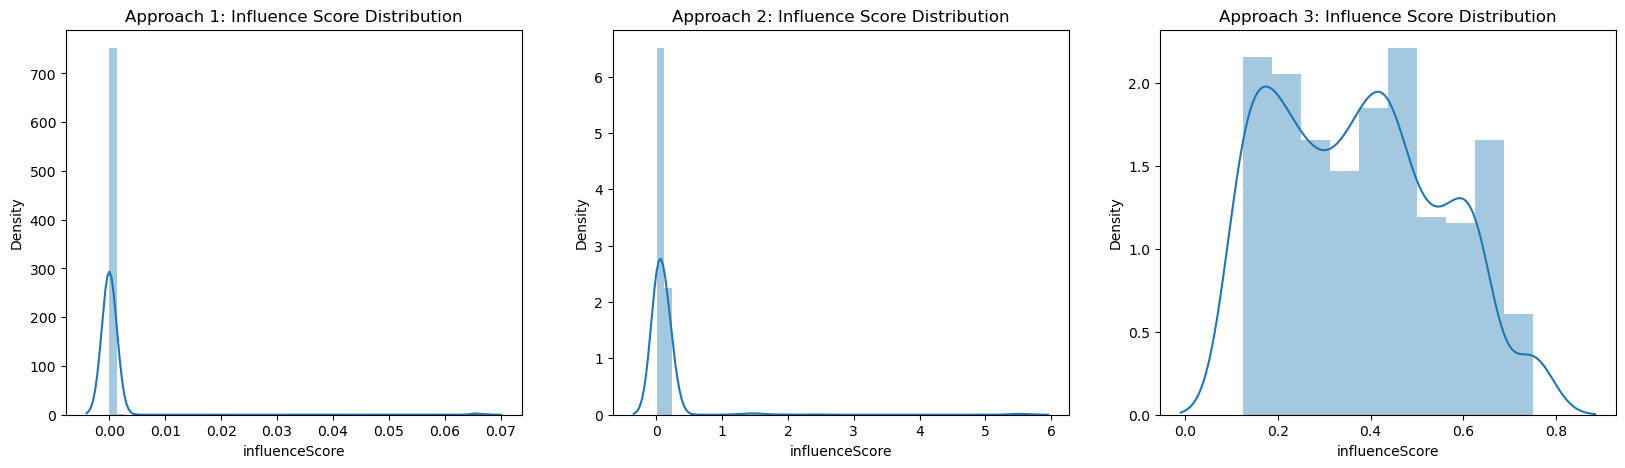

In [71]:
#1. Scoring Comparison
    #1.1. Final Score Distribution 
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
sns.distplot(influenceScoreData_A1["influenceScore"], ax = ax1).set_title('Approach 1: Influence Score Distribution')
sns.distplot(influenceScoreData_A2["influenceScore"], ax = ax2).set_title('Approach 2: Influence Score Distribution')
sns.distplot(influenceScoreData_A3["influenceScore"], ax = ax3).set_title('Approach 3: Influence Score Distribution')
plt.show()

ValueError: could not convert string to float: '8/7/'

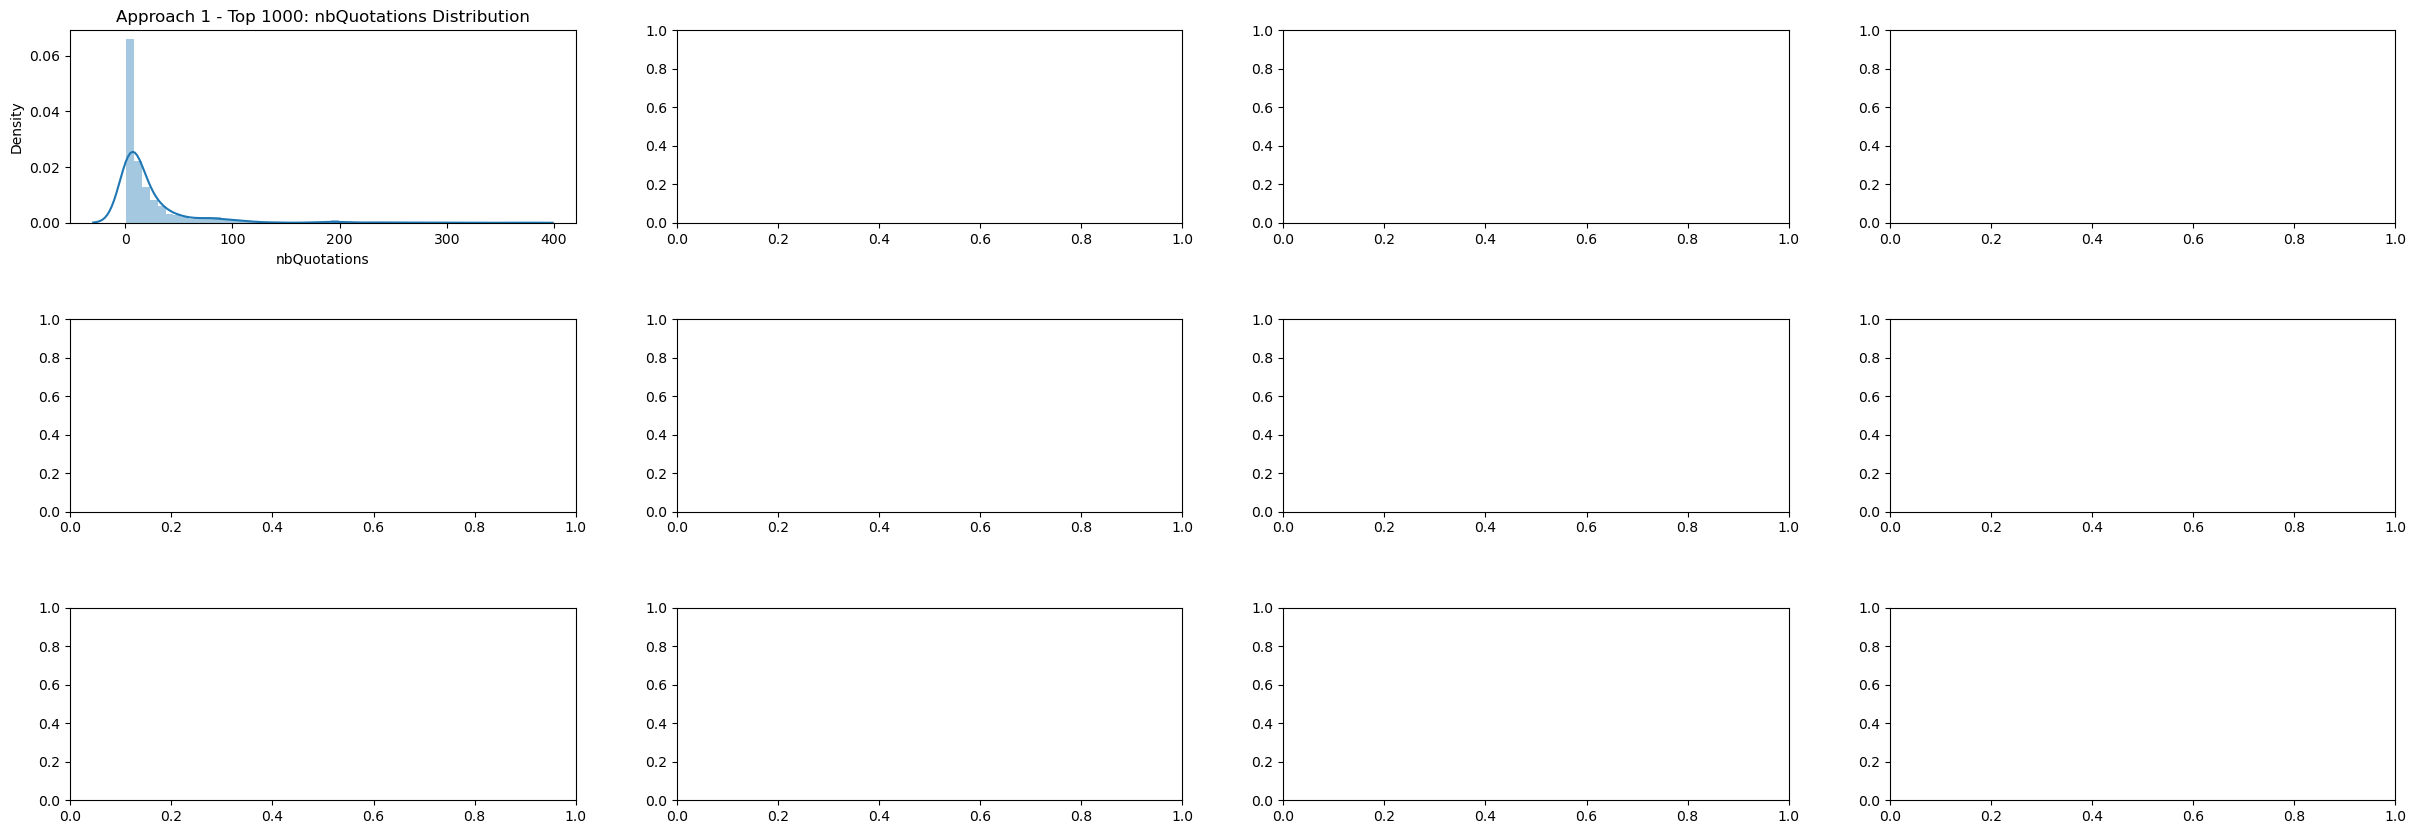

In [72]:
    #1.2. Top 1000 for each approaches - Deep diving the characteristics for each variables

top = 1000

top_A1 = influenceScoreData_A1[["title","year", "nbQuotations", "pageRankPublication", "authorP2", "influenceScore"]].sort_values(by = "influenceScore", ascending = False).head(top).reset_index(drop = True)
top_A2 = influenceScoreData_A2[["title","year", "nbQuotations", "pageRankPublication", "authorP2", "influenceScore"]].sort_values(by = "influenceScore", ascending = False).head(top).reset_index(drop = True)
top_A3 = influenceScoreData_A3[["title","year", "nbQuotations", "pageRankPublication", "authorP2", "influenceScore"]].sort_values(by = "influenceScore", ascending = False).head(top).reset_index(drop = True)

        #Distribution Visualization

fig, ax = plt.subplots(3,4,figsize=(30,10))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

#Approach 1
sns.distplot(top_A1[(top_A1["nbQuotations"] != 0)]["nbQuotations"], ax = ax[0,0]).set_title('Approach 1 - Top '+str(top)+': nbQuotations Distribution') 
sns.distplot(top_A1["year"], ax = ax[0,1]).set_title('Approach 1 - Top '+str(top)+': Year Distribution')
sns.distplot(top_A1["pageRankPublication"], ax = ax[0,2]).set_title('Approach 1 - Top '+str(top)+': Pagerank Publication Distribution')
sns.distplot(top_A1["authorP2"], ax = ax[0,3]).set_title('Approach 1 - Top '+str(top)+': Author Score Distribution')

#Approach 2
sns.distplot(top_A2["nbQuotations"], ax = ax[1,0], color=".2").set_title('Approach 2 - Top '+str(top)+': nbQuotations Distribution')
sns.distplot(top_A2["year"], ax = ax[1,1], color=".2").set_title('Approach 2 - Top '+str(top)+': Year Distribution')
sns.distplot(top_A2["pageRankPublication"], ax = ax[1,2], color=".2").set_title('Approach 2 - Top '+str(top)+': Pagerank Publication Distribution')
sns.distplot(top_A2["authorP2"], ax = ax[1,3], color=".2").set_title('Approach 2 - Top '+str(top)+': Author Score Distribution')

#Approach 3
sns.distplot(top_A3["nbQuotations"], ax = ax[2,0], color="orange").set_title('Approach 3 - Top '+str(top)+': nbQuotations Distribution')
sns.distplot(top_A3["year"], ax = ax[2,1], color="orange").set_title('Approach 3 - Top '+str(top)+': Year Distribution')
sns.distplot(top_A3["pageRankPublication"], ax = ax[2,2], color="orange").set_title('Approach 3 - Top '+str(top)+': Pagerank Publication Distribution')
sns.distplot(top_A3["authorP2"], ax = ax[2,3], color="orange").set_title('Approach 3 - Top '+str(top)+': Author Score Distribution')

plt.show()